In [3]:
import pandas as pd
import numpy as np
import QuantLib as ql
from calendar import monthrange
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'


calculation_date = ql.Date(5, 2, 2016)
ql.Settings.instance().evaluationDate = calculation_date

# conversion of python date to QuantLib date
def dt_to_ql_Date(dt): return ql.Date(dt.day, dt.month, dt.year)

# Description
Notebook builds inflation curves similar to that in ORE (Example 17). These curves are built entirely from Zero coupon inflation swaps (ZCIS).

Methodology for the construction is described in the accompanying document `inflation_curves.md`

We note that the methodology in ORE isn't completely aligned with Kerkhof. ORE does not interpolate the lagged value to get $I(0)$ and assings the resulting $I(T)$ value to a date that does not need to be end month. E.g. $I(T)$ can represent CPI(`2030-12-05`). Kerkhof is more methodological, $I(0)$ might be an _interpolated_ lagged value, resulting $I(T)$ might be assigned to just end of month. This however still depends on the market (EU vs US, ...). 

Therefore, we present both methods. The results are, however, very close.

# ORE Example 17

In [4]:
CPI_index = 'UKRPI'
inflation_lag  = {'UKRPI': '2M', 'USCPI': '3M', 'EUHICP':'3M', 'EUHICPXT':'3M', 'FRHICP':'3M'}[CPI_index]

discount_curve = pd.read_excel('data/inflation_inputs.xlsx', sheet_name = 'ir_curves')
zcis_quotes    = pd.read_excel('data/inflation_inputs.xlsx', sheet_name = 'zcis_quotes')[['tenor', CPI_index]]
fixings        = pd.read_excel('data/inflation_inputs.xlsx', sheet_name = 'fixings').query('CPI_index == @CPI_index')
fixings = fixings.set_index(fixings['date'].astype(str).str[:4] + '-' + fixings['date'].astype(str).str[4:6])
fixings = fixings.rename_axis('month')


display(zcis_quotes)
display(fixings)

,tenor,UKRPI
0,1Y,0.028250
1,2Y,0.029425
2,3Y,0.029750
3,4Y,0.029830
4,5Y,0.030000
5,6Y,0.030100
6,7Y,0.030080
7,8Y,0.030090
8,9Y,0.030130
9,10Y,0.030445


,date,CPI_index,value
month,,,
2014-11,20141101,UKRPI,257.5
2014-12,20141201,UKRPI,258.1
2015-01,20150101,UKRPI,258.2
2015-02,20150201,UKRPI,258.8
2015-03,20150301,UKRPI,259.1
2015-04,20150401,UKRPI,259.2
2015-05,20150501,UKRPI,259.3
2015-06,20150601,UKRPI,259.4
2015-07,20150701,UKRPI,259.5


# Computation of $I(0)$ based on Kerkhof vs ORE
Method comparison:
- Kerkof: interpolate $I(0)$ from CPI lagged (earlier and later)
- ORE: use $I(0)$ as the earlier lagged CPI (no interpolation)

In [5]:
first_I_date  = ql.Date(1, calculation_date.month(), calculation_date.year())
second_I_date = first_I_date + ql.Period('1M')

first_CPI_month   = str((first_I_date  - ql.Period(inflation_lag)).to_date())[:7]
second_CPI_month  = str((second_I_date - ql.Period(inflation_lag)).to_date())[:7]

first_CPI  = fixings.loc[first_CPI_month, 'value']
second_CPI = fixings.loc[second_CPI_month, 'value']

print(f'------------KERKHOF--------------------------------------')
print(f'The following interpolation will happen to get I(t=0), where t={str(calculation_date.to_date())} from lagged CPI values:')
print(f'I({str(first_I_date.to_date())})=CPI({first_CPI_month})={first_CPI}')
print(f'I({str(second_I_date.to_date())})=CPI({second_CPI_month})={second_CPI}')

days_in_month = monthrange(calculation_date.year(), calculation_date.month())[1]
I0_kerkhof = (first_CPI + (calculation_date-first_I_date)/days_in_month * (second_CPI - first_CPI))

print(f'I(0)=I({str(calculation_date.to_date())})={I0_kerkhof}')
print('----------------------------------------------------------')

print('--------------------ORE-----------------------------------')
print(f'In ORE I(t=0), where t={str(calculation_date.to_date())} the following assingment will happen based on lagged CPI:')
print(f'I(0)=I({str(calculation_date.to_date())})=CPI({first_CPI_month})={first_CPI}')
I0_ore = first_CPI

------------KERKHOF--------------------------------------
The following interpolation will happen to get I(t=0), where t=2016-02-05 from lagged CPI values:
I(2016-02-01)=CPI(2015-12)=260.6
I(2016-03-01)=CPI(2016-01)=258.8
I(0)=I(2016-02-05)=260.35172413793106
----------------------------------------------------------
--------------------ORE-----------------------------------
In ORE I(t=0), where t=2016-02-05 the following assingment will happen based on lagged CPI:
I(0)=I(2016-02-05)=CPI(2015-12)=260.6


,date,CPI_kerkhof,CPI_ore
0,2016-12-05,267.706660,267.961950
1,2017-12-05,275.898844,276.161945
2,2018-12-05,284.286253,284.557354
3,2019-12-05,292.834752,293.114004
4,2020-12-05,301.819004,302.106824
5,2021-12-05,311.054709,311.351337
6,2022-12-05,320.373911,320.679425
7,2023-12-05,330.036389,330.351117
8,2024-12-05,340.086016,340.410327
9,2025-12-05,351.405554,351.740660


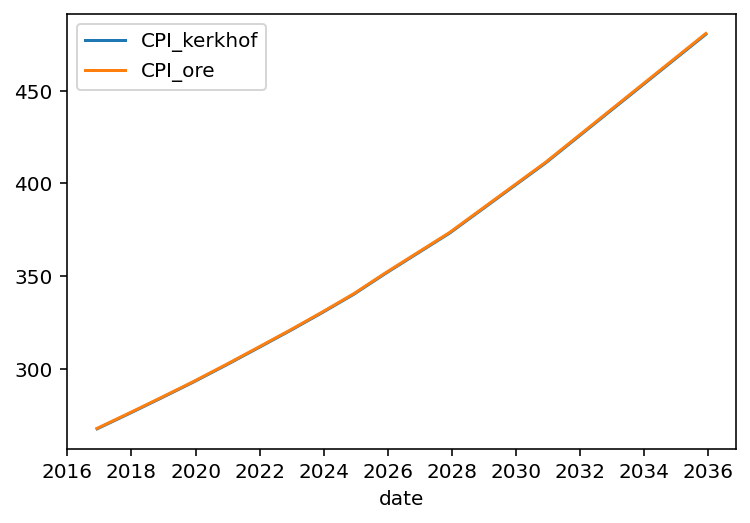

In [6]:
CPI_T_kerkhof = []
CPI_T_ore = []
CPI_fixing_date = []

for tenor, quote in zcis_quotes.values:   
    years = ql.Period(tenor).length()
    T     = calculation_date + ql.Period(tenor)

    CPI_fixing_date.append(T - ql.Period(inflation_lag))
    CPI_T_kerkhof.append(I0_kerkhof * (1+quote)**years)
    CPI_T_ore.append(I0_ore * (1+quote)**years)

results = pd.DataFrame({'date':pd.Series(CPI_fixing_date).apply(ql.Date.to_date),'CPI_kerkhof': CPI_T_kerkhof, 'CPI_ore':CPI_T_ore})
display(results)

results.set_index('date').plot();



# Example based on Stackoverflow
https://stackoverflow.com/questions/55716965/how-to-build-an-inflation-term-structure-in-quantlib

,date,CPI
0,2020-01-18,257.050864
1,2021-01-18,261.972673
2,2022-01-18,267.098167
3,2023-01-18,272.402532
4,2024-01-18,278.491737
5,2025-01-18,283.931946
6,2026-01-18,290.077268
7,2027-01-18,296.534484
8,2028-01-18,303.520417
9,2029-01-18,310.737150


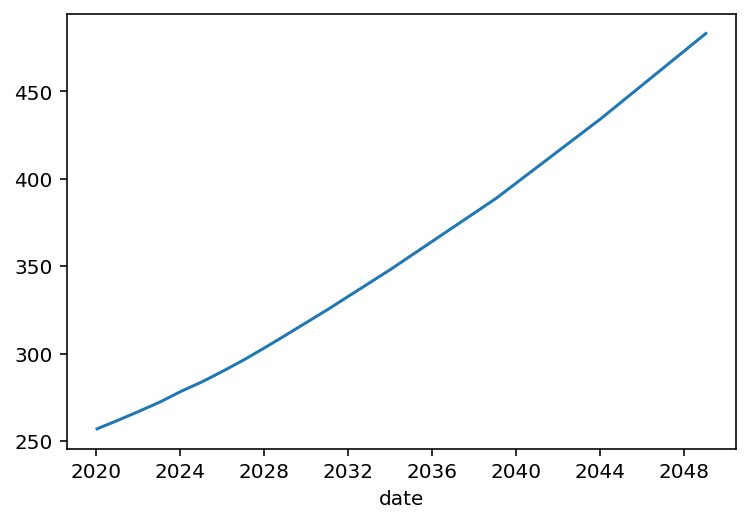

In [7]:
import QuantLib as ql
import pandas as pd

fixing_rate      = 252.0
observation_date = ql.Date(17, 4, 2019)

zciisData = [(ql.Date(18,4,2020), 1.9948999881744385),
              (ql.Date(18,4,2021), 1.9567999839782715),
              (ql.Date(18,4,2022), 1.9566999673843384),
              (ql.Date(18,4,2023), 1.9639999866485596),
               (ql.Date(18,4,2024), 2.017400026321411),
                 (ql.Date(18,4,2025), 2.0074000358581543),
                 (ql.Date(18,4,2026), 2.0297999382019043),
                 (ql.Date(18,4,2027), 2.05430006980896),
                 (ql.Date(18,4,2028), 2.0873000621795654),
                 (ql.Date(18,4,2029), 2.1166999340057373),
                 (ql.Date(18,4,2031), 2.152100086212158),
                 (ql.Date(18,4,2034), 2.18179988861084),
                 (ql.Date(18,4,2039), 2.190999984741211),
                 (ql.Date(18,4,2044), 2.2016000747680664),
                 (ql.Date(18,4,2049), 2.193000078201294)]

fixing_dates = []
CPI_computed = []
for tenor, quote in zciisData:
    fixing_dates.append(tenor - ql.Period('3M')) # this is 'fixing date' t
    pay_date = ql.ActualActual().yearFraction(observation_date, tenor) # this is year fraction of 'pay date' T
    CPI_computed.append(fixing_rate * (1+quote/100)**(pay_date))

results = pd.DataFrame({'date': pd.Series(fixing_dates).apply(ql.Date.to_date), 'CPI':CPI_computed})
display(results)
results.set_index('date')['CPI'].plot();